![BHM2022_logo](logo_brainhack_blanc.jpg)
# MNE-python 

# Check libraries
## Requirements:
- numpy
- mne
- xarray
- matplotlib

In [1]:
import sys
!{sys.executable} -m pip install numpy mne xarray matplotlib autoreject
    

## Import libraries

In [2]:
import numpy as np
import mne
from autoreject import AutoReject, get_rejection_threshold
import xarray as xr
import os
import os.path as op
import matplotlib.pyplot as plt
%matplotlib qt


## Download MNE sample database

In [3]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = (op.join(sample_data_folder, 'MEG', 'sample', 'sample_audvis_filt-0-40_raw.fif'))


## Print RAW information

In [4]:
# Load RAW file
raw = mne.io.read_raw_fif(sample_data_raw_file, preload=True)
print(raw)
print(raw.info)


Opening raw data file /home/jerry/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~122.9 MB, data loaded>
<Info | 15 non-empty values
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 GRAD, 102 MAG, 9 STIM, 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 projs: P

## Plot PSD (power spectral density)

Effective window size : 13.639 (s)
Effective window size : 13.639 (s)
Effective window size : 13.639 (s)


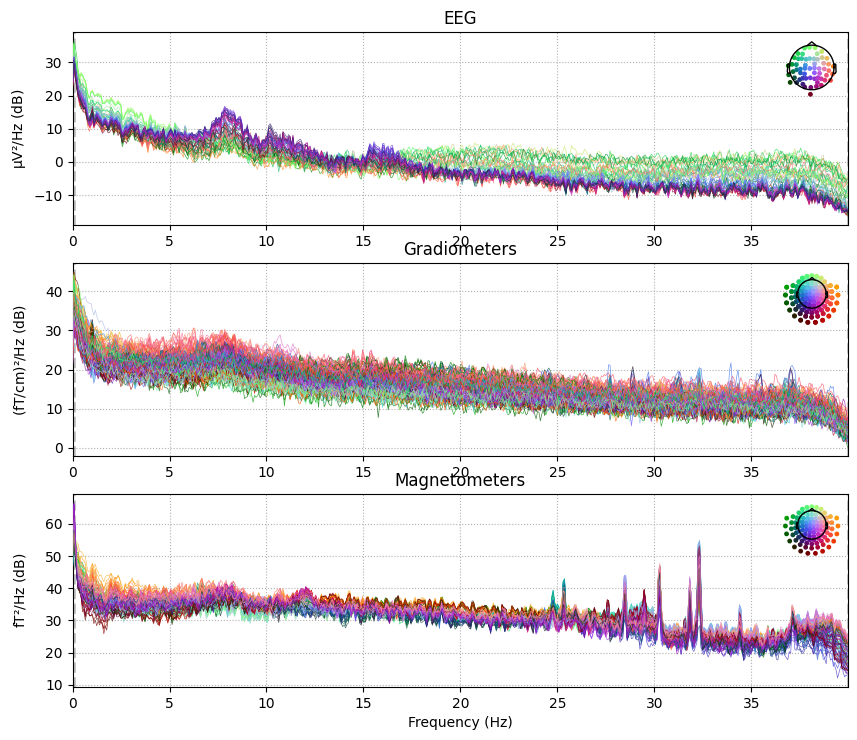

In [5]:
# Plot individual channels' PSD...
raw.plot_psd(fmax=40)


Effective window size : 13.639 (s)
Effective window size : 13.639 (s)
Effective window size : 13.639 (s)


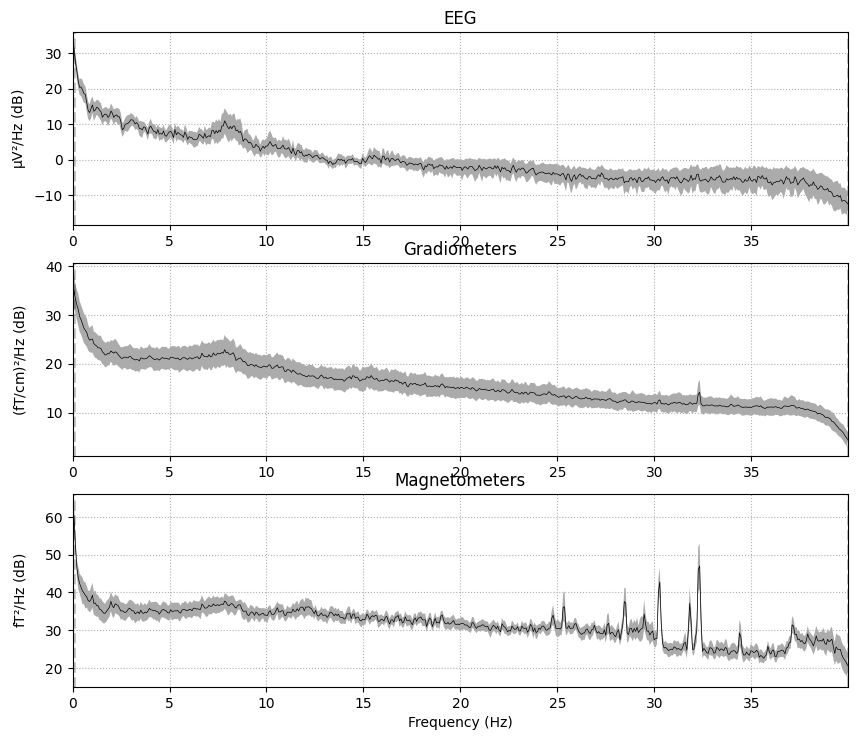

In [6]:
# ... and their average
raw.plot_psd(fmax=40, average=True)


## Visualize channels' data

In [7]:
# This kind of visualization allows a channel rejection by visual criteria, 
# artefacted channels can be manually selected, they will be recorded in tye 'bad_cannels' list
raw.plot(duration=5, n_channels=30)
print(raw.info['bads'])


['MEG 2443', 'EEG 053']
Channels marked as bad: ['MEG 2443', 'EEG 053']


## Blinks / saccades / heartbeat removal with ICA

### Method 1, extracting a given number of main components

In [ ]:
ica = mne.preprocessing.ICA(n_components=20, random_state=13, max_iter=800)
ica.fit(raw)
ica.plot_components(picks=range(20))
ica.plot_properties(raw, picks=[1, 2])


### Method 2, extracting the components that explains the xx% of data variance 

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by explained variance: 204 components
Fitting ICA took 85.6s.


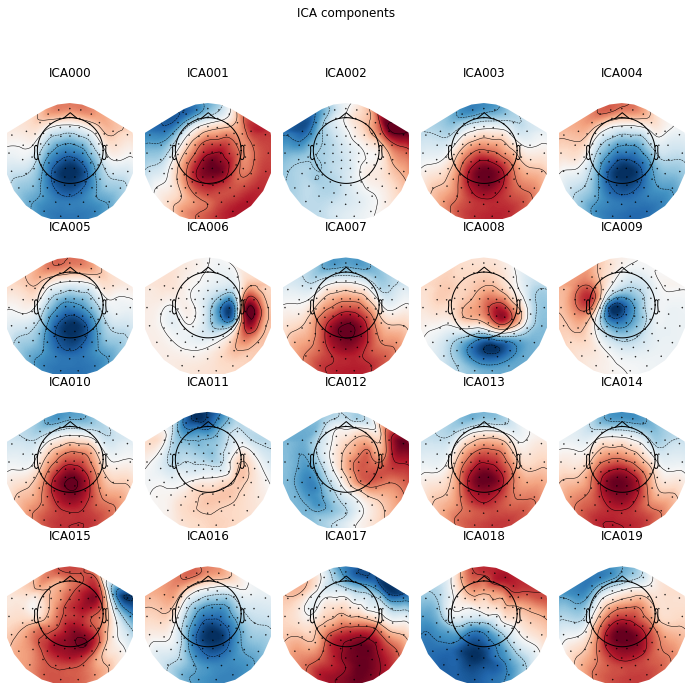

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


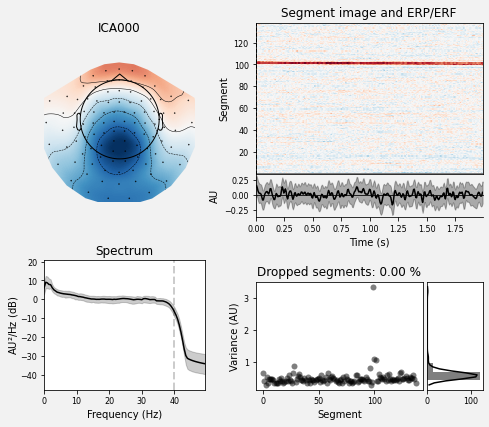

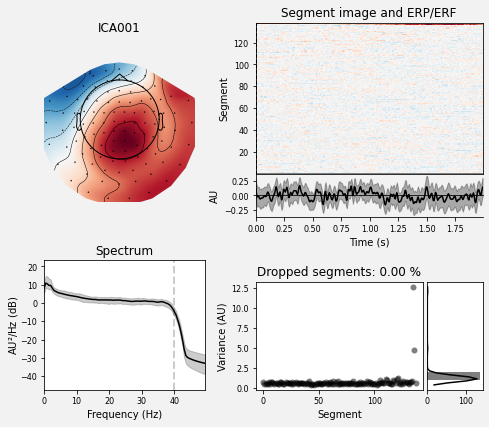

[<Figure size 504x432 with 6 Axes>, <Figure size 504x432 with 6 Axes>]

In [37]:
# ! Time consuming
ica = mne.preprocessing.ICA(n_components=.99, random_state=13, max_iter=800)
ica.fit(raw)
ica.plot_components(picks=range(20))
ica.exclude = [0, 1]
ica.plot_properties(raw, picks=ica.exclude)


### Visualize components' time course

Creating RawArray with float64 data, n_channels=199, n_times=41700
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


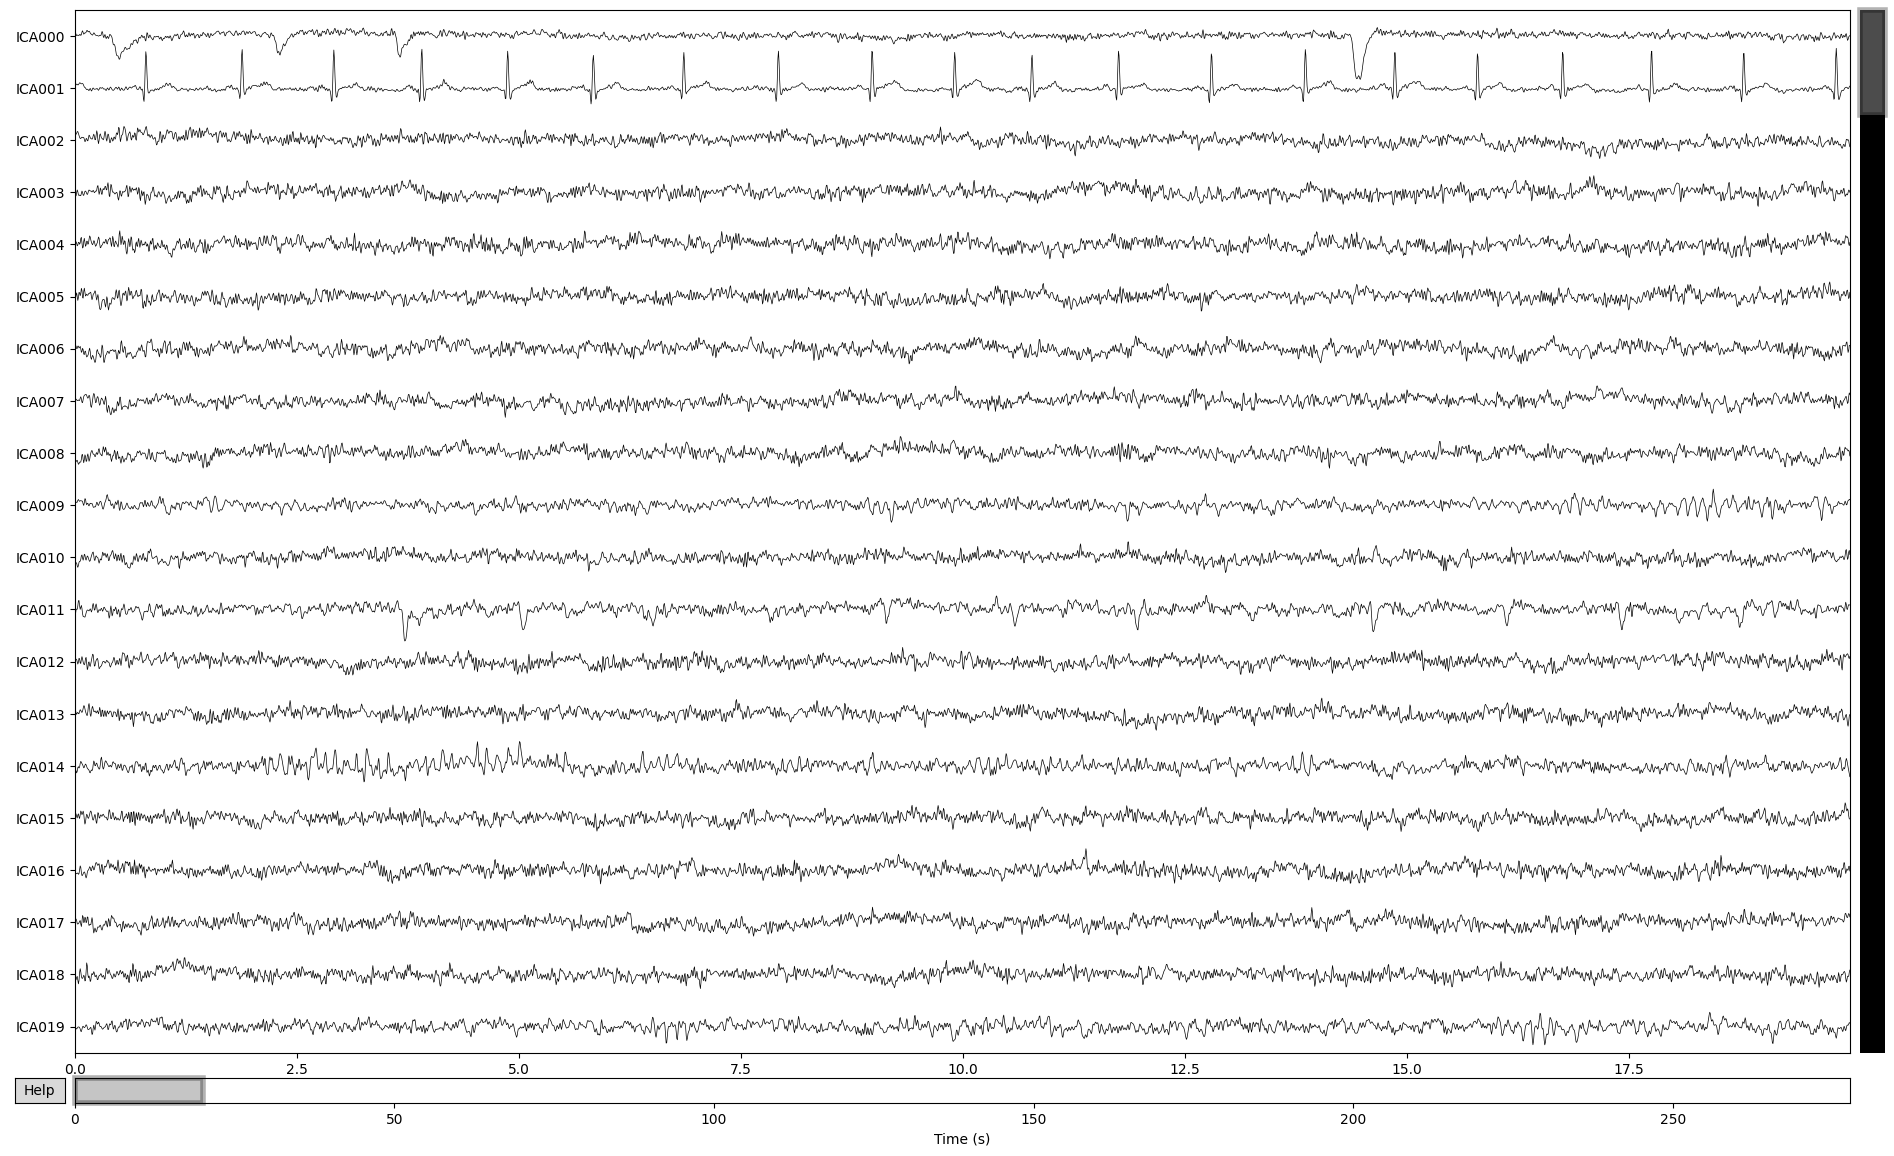

In [9]:
ica.plot_sources(raw)


### Result of an ICA

Applying ICA to Raw instance
    Transforming to ICA space (198 components)
    Zeroing out 5 ICA components
    Projecting back using 364 PCA components


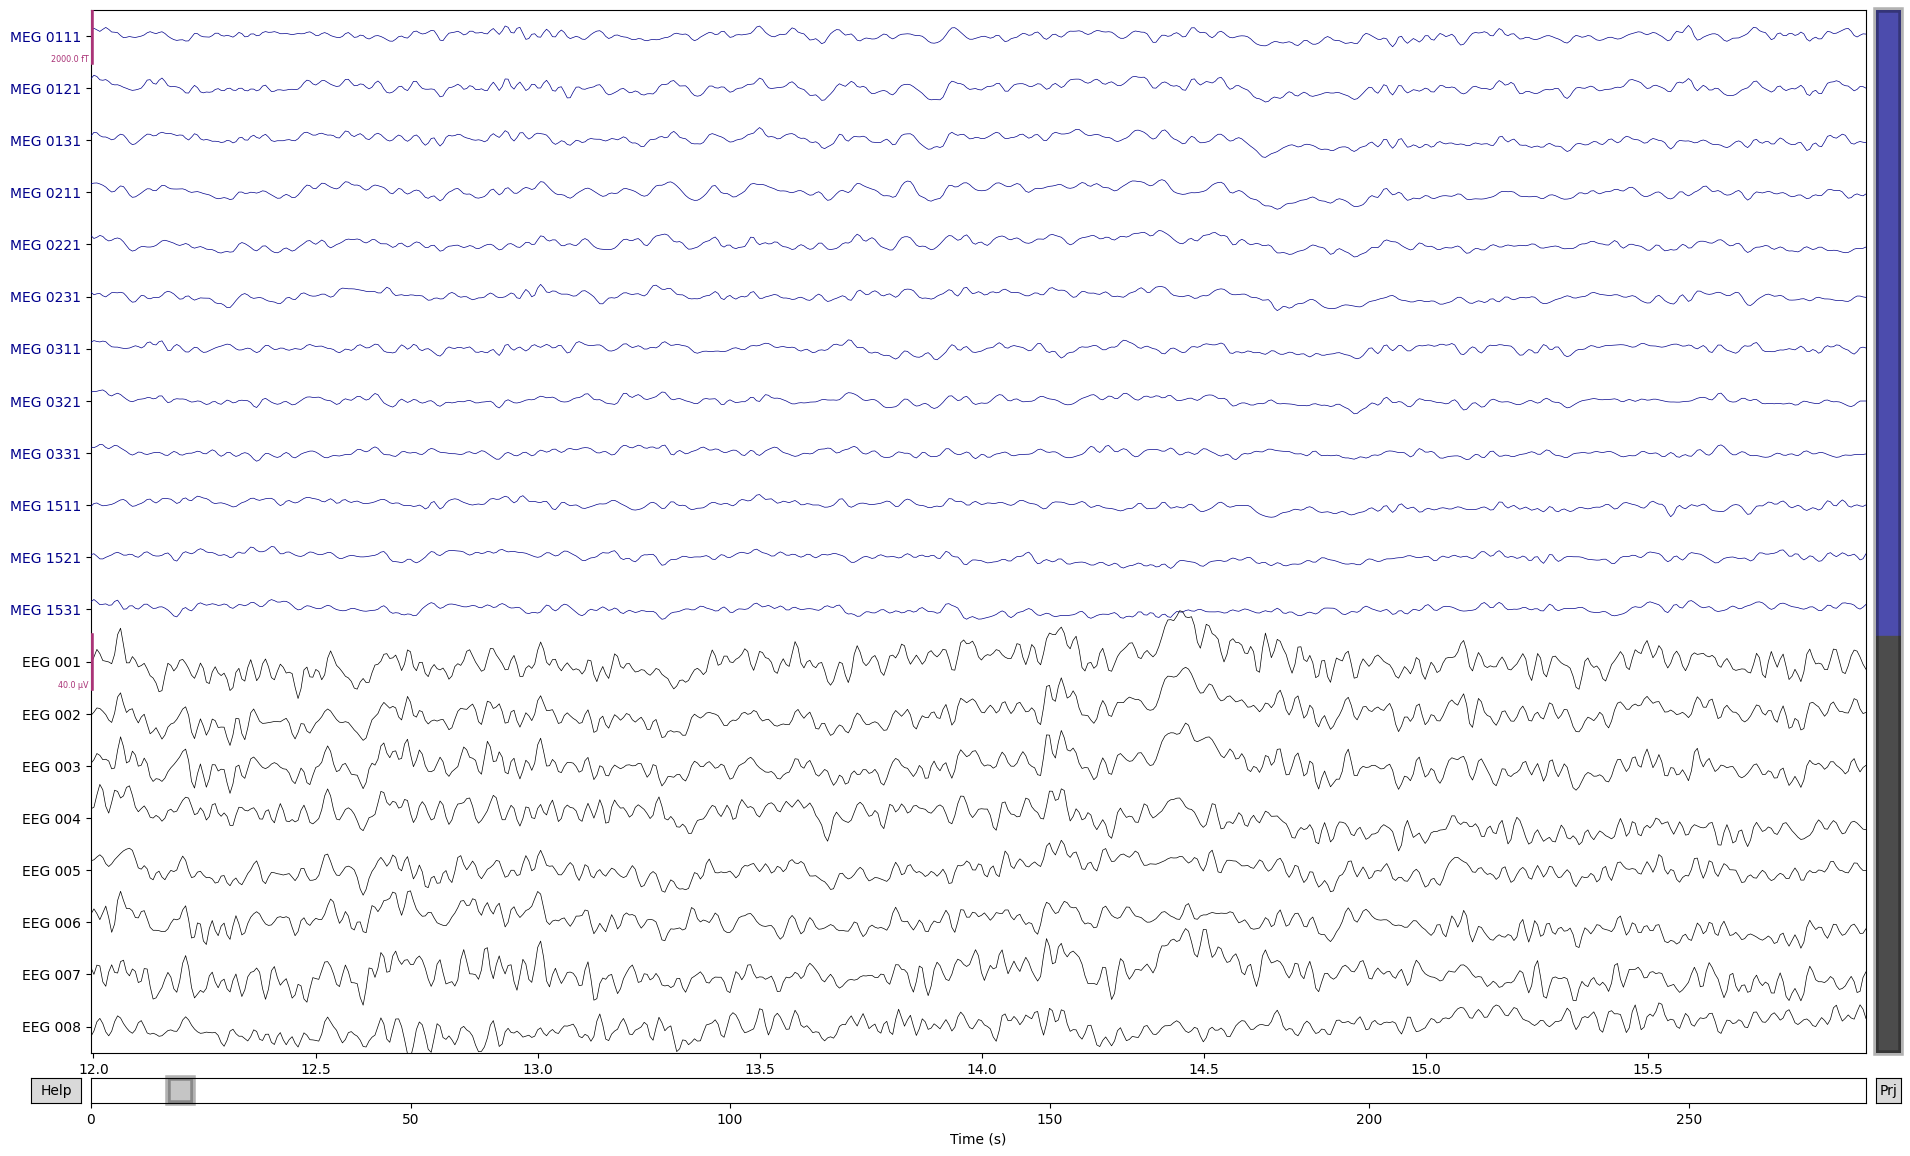

Channels marked as bad: ['MEG 2443', 'EEG 053']
Channels marked as bad: ['MEG 2443', 'EEG 053']


In [10]:
orig_raw = raw.copy()
raw.load_data()
ica.apply(raw)

# show some frontal channels to clearly illustrate the artifact removal
chs = ['MEG 0111', 'MEG 0121', 'MEG 0131', 'MEG 0211', 'MEG 0221', 'MEG 0231',
       'MEG 0311', 'MEG 0321', 'MEG 0331', 'MEG 1511', 'MEG 1521', 'MEG 1531',
       'EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006',
       'EEG 007', 'EEG 008']
#chs = ['MEG 0511', 'MEG 0521', 'MEG 0811', 'MEG 0911', 'MEG 0921', 'EEG 001', 
#       'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006',
#       'EEG 007']
chan_idxs = [raw.ch_names.index(ch) for ch in chs]
orig_raw.plot(order=chan_idxs, start=12, duration=4)
raw.plot(order=chan_idxs, start=12, duration=4)

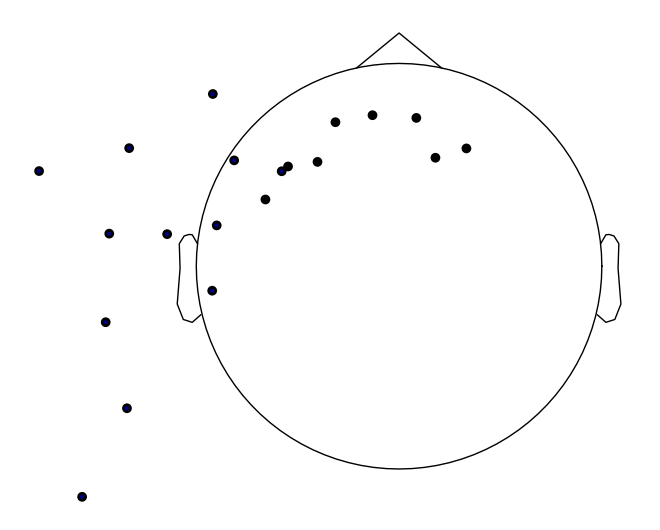

In [11]:
raw.copy().pick_channels(chs).plot_sensors(ch_type='all')

## Epoching

### Events identification

In [12]:
events = mne.find_events(raw, stim_channel='STI 014')
print(events[:10])  # show the first 5


319 events found
Event IDs: [ 1  2  3  4  5 32]
[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]
 [7506    0    3]
 [7612    0    1]
 [7709    0    4]
 [7810    0    2]
 [7916    0    3]]


In [13]:
event_dict = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
              'visual/right': 4, 'smiley': 5, 'buttonpress': 32}


### Rejecting bad Epochs

#### Method 1: rejection by manual thresholding

Not setting metadata
Not setting metadata
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Loading data for 319 events and 106 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EEG : ['EEG 008']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
10 bad epochs dropped
['MEG 2443', 'EEG 053']
Not setting metadata
Not setting metadata
309 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting m

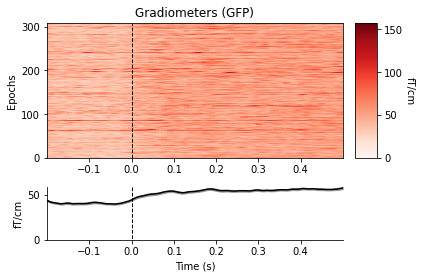

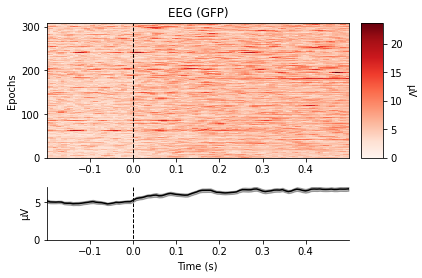

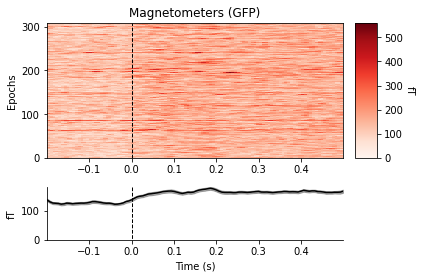

[<Figure size 432x288 with 3 Axes>,
 <Figure size 432x288 with 3 Axes>,
 <Figure size 432x288 with 3 Axes>]

In [14]:
%matplotlib inline
reject_criteria = dict(mag=4000e-15,     # 4000 fT
                       grad=4000e-13,    # 4000 fT/cm
                       eeg=150e-6,       # 150 µV
                       eog=250e-6)       # 250 µV
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.2, tmax=0.5,
                    reject=reject_criteria, preload=True)
print(epochs.info['bads'])
# If you want to apply a baseline (in this stage mostly for visualization)
# epochs.apply_baseline((-.2, .5))
epochs.plot_image()


#### Method 2: rejection by automatic threshold detection

Not setting metadata
Not setting metadata
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Loading data for 319 events and 106 original time points ...
0 bad epochs dropped
Estimating rejection dictionary for mag
Estimating rejection dictionary for grad
Estimating rejection dictionary for eeg
Estimating rejection dictionary for eog
{'mag': 1.347829278528639e-11, 'grad': 1.0248357537170116e-10, 'eeg': 9.170227524439242e-05, 'eog': 0.00012173770663573681}
Not setting metadata
Not setting metadata
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Loading data for 319 events and 106 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based

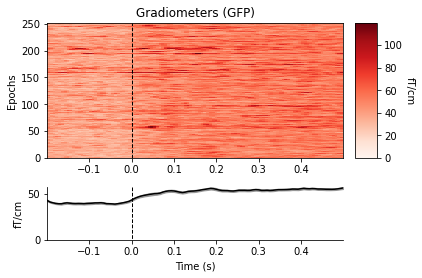

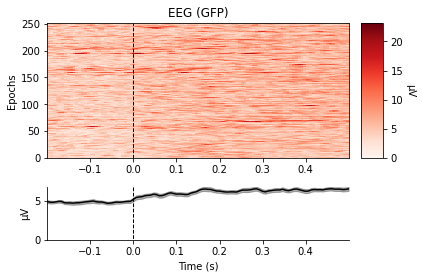

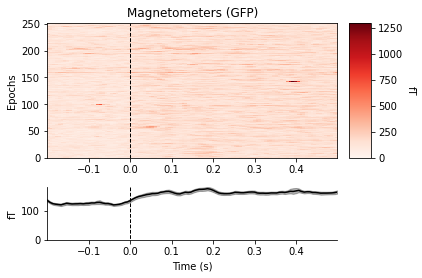

['MEG 2443', 'EEG 053']


In [15]:
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.2, tmax=0.5, preload=True)
reject_criteria = get_rejection_threshold(epochs)
print(reject_criteria)
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.2, tmax=0.5,
                    reject=reject_criteria, preload=True)
# epochs.apply_baseline((-.2, .5))
epochs.plot_image()
print(epochs.info['bads'])


#### Method 3: Autoreject, using machine learning to detect bad epochs

In [16]:
# epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.2, tmax=0.5, preload=True)
# ar = AutoReject(n_jobs=-1, verbose=False)
# epochs_clean = ar.fit_transform(epochs)
# print(epochs.info['bads'])
# epochs.plot_image()


### Selecting epochs of interest

In [17]:
conds_we_care_about = ['auditory/left', 'auditory/right',
                       'visual/left', 'visual/right']
# Not necessary, but if needed to equalize the number of different  categories of events
epochs.equalize_event_counts(conds_we_care_about)
# Dividing epochs
aud_epochs = epochs['auditory']
vis_epochs = epochs['visual']
# Free up memory
# del raw, epochs 


Dropped 17 epochs: 55, 61, 78, 84, 85, 135, 150, 151, 153, 158, 161, 162, 196, 206, 210, 218, 219


#### Visualizing single channel epochs

In [18]:
%matplotlib qt
aud_epochs.plot_image(picks=['MEG 1332'])
aud_epochs.plot_image(picks=['EEG 055'])


Not setting metadata
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[<Figure size 432x288 with 4 Axes>]

## Computing Evoked signals

Multiple channel types selected, returning one figure per type.
combining channels using "gfp"
combining channels using "gfp"


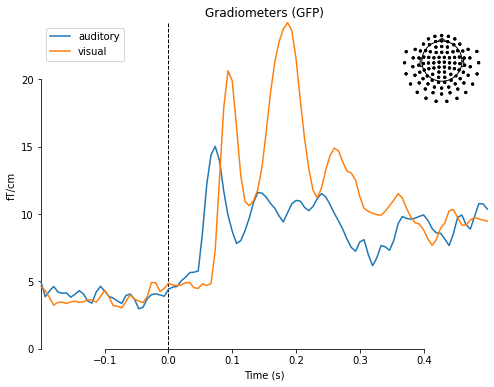

combining channels using "gfp"
combining channels using "gfp"


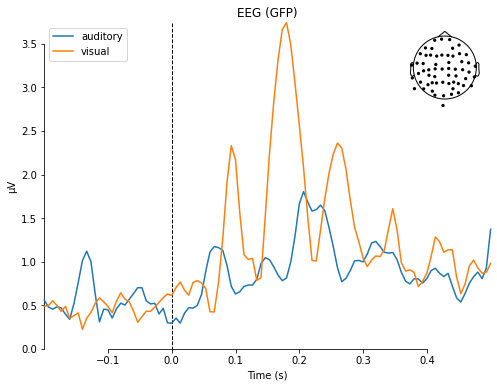

combining channels using "gfp"
combining channels using "gfp"


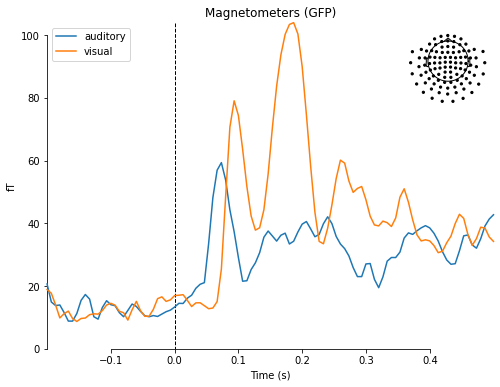

[<Figure size 576x432 with 2 Axes>,
 <Figure size 576x432 with 2 Axes>,
 <Figure size 576x432 with 2 Axes>]

In [19]:
%matplotlib inline
aud_evoked = aud_epochs.average()
vis_evoked = vis_epochs.average()

mne.viz.plot_compare_evokeds(dict(auditory=aud_evoked, visual=vis_evoked),
                             legend='upper left', show_sensors='upper right')


## Time-frequency analysis

In [20]:
%matplotlib qt
frequencies = np.geomspace(5, 30, 20)
n_cycles = frequencies / 3.
power = mne.time_frequency.tfr_morlet(aud_epochs, n_cycles=n_cycles, return_itc=False,
                                      freqs=frequencies, average=False)
power.average().plot(picks=['MEG 1332'], baseline=(-.2, .5), mode='zscore')
# power.plot(['MEG 1332'])


Not setting metadata
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>
Applying baseline correction (mode: zscore)


[<Figure size 432x288 with 2 Axes>]

Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>
Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>
Applying baseline correction (mode: zscore)


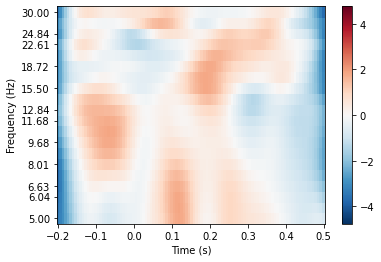

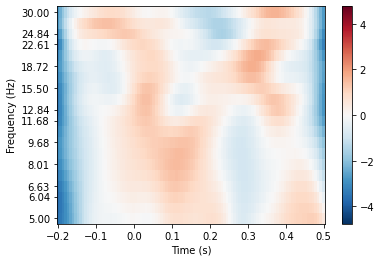

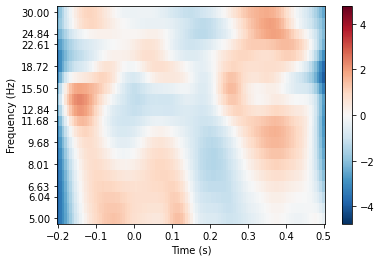

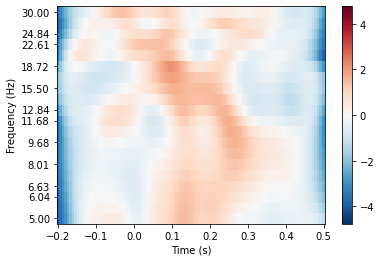

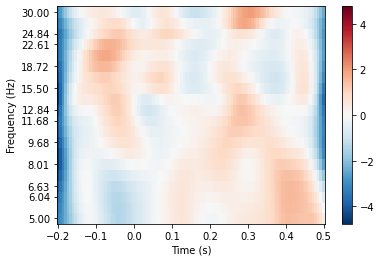

[<Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>]

In [21]:
%matplotlib inline
power.average().plot(picks=range(0, 5), baseline=(-.2, .5), mode='zscore')

## Forward model
Before computing the forward model we need to compute:
    - Coregistration
    - Boundary Element Model (BEM)
    - Source space

### Coregistration
#### (FreeSurfer needed)

In [22]:
%%bash
export SUBJECTS_DIR=$HOME/mne_data/MNE-sample-data/MEG
export FREESURFER_HOME=/usr/local/freesurfer/7.3.2/
source $FREESURFER_HOME/SetUpFreeSurfer.sh
mne coreg


Coregistration: Excluding 0 head shape points with distance >= inf m.


In [23]:
# The output is a transformation matrix that we can find at:
trans = op.join(sample_data_folder, 'MEG', 'sample', 'sample_audvis_raw-trans.fif')

### BEM

In [24]:
bem_model = mne.make_bem_model(subject='sample', subjects_dir=op.join(sample_data_folder, 'subjects'))
bem_solution = mne.make_bem_solution(bem_model)

bem_dir = op.join(sample_data_folder, 'subjects', 'sample', 'bem', 'flash')
# mne.write_bem_solution(bem_dir, bem_solution, overwrite=True)


Creating the BEM geometry...
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
outer skin  CM is  -0.12  -0.14  22.79 mm
outer skull CM is   0.70  -9.88  44.01 mm
inner skull CM is   0.67 -10.01  44.26 mm
Checking that surface outer skull is inside surface outer skin  ...
Checking that surface inner skull is inside surface outer skull ...
Checking distance between outer skin  and outer skull surfaces...
Minimum distance between the outer skin  and outer skull surfaces is approximately    3.7 mm
Checking distance between outer skull and inner skull surfaces...
Minimum distance between the outer skull and inner skull surfaces is approximately    3.5 mm
Surfaces passed the basic topology checks.
Complete.

Approximation method : Linear collocation

Three-layer model surfaces loaded.
Computing the linear collocation solu

#### Visualize BEM

In [25]:
%matplotlib qt
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(projection='3d')
for i in range(3):
    vertex = bem_solution.get('surfs')[i]['rr']
    x, y, z = vertex[:,0],vertex[:,1], vertex[:,2]
    ax.scatter(x, y, z)
fig.show()


### Source space

In [26]:
# Surface source space
src = mne.setup_source_space('sample', spacing='oct4', add_dist='patch', 
                             subjects_dir=op.join(sample_data_folder, 'subjects'), n_jobs=-1)

# Volume source space
#vol_src = mne.setup_volume_source_space('sample', subjects_dir=op.join(sample_data_folder, 'subjects'), 
#                                        surface=op.join(bem_dir, 'inner_skull.surf'), add_interpolator=False) 


Setting up the source space with the following parameters:

SUBJECTS_DIR = /home/jerry/mne_data/MNE-sample-data/subjects
Subject      = sample
Surface      = white
Octahedron subdivision grade 4

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading /home/jerry/mne_data/MNE-sample-data/subjects/sample/surf/lh.white...
Mapping lh sample -> oct (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from /home/jerry/mne_data/MNE-sample-data/subjects/sample/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 258/155407 selected to source space (oct = 4)

Loading /home/jerry/mne_data/MNE-sample-data/subjects/sample/surf/rh.white...
Mapping rh sample -> oct (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from /home/jerry/mne_data/MNE-sample-data/subjects/sample/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 258/156866 selected to source space

### Computing the forward model

In [27]:
fwd = mne.make_forward_solution(info=raw.info, trans=trans, src=src, bem=bem_solution,
                                meg=True, eeg=False, mindist=5.0, n_jobs=-1,
                                verbose=False)

# Convert the forward solution in order to take only components normal to the surface
fwd = mne.forward.convert_forward_solution(fwd, surf_ori=True, force_fixed=False, use_cps=False)


    Converting to surface-based source orientations...
    [done]


## Estimating power at source level 
There are different thecniques, this is just one possible example

### Computing Cross-Spectral Density (CSD)

<ipython-input-28-4ce0211de54e>:5: UserWarning: At least one of the wavelets (79) is longer than the signal (69). Consider using a longer signal or shorter wavelets.
  tmin=-.2, tmax=0., n_jobs=16, verbose=False)
/home/jerry/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


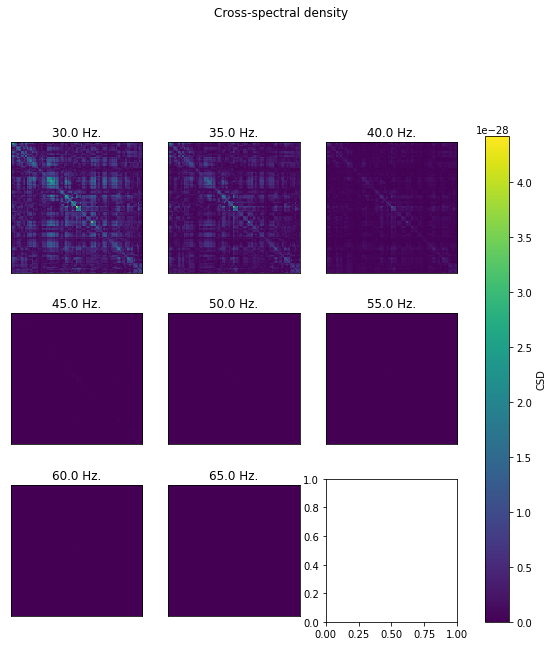

In [28]:
%matplotlib inline
freqs = np.arange(30., 70., 5.)
#freqs = np.array([5.])
bln_csd = mne.time_frequency.csd_morlet(epochs, freqs, n_cycles=freqs / 3, picks=['mag'], 
                                        tmin=-.2, tmax=0., n_jobs=16, verbose=False)
csd = mne.time_frequency.csd_morlet(epochs, freqs, n_cycles=freqs / 3, picks=['mag'], 
                                    tmin=-.2, tmax=.5, n_jobs=16, verbose=False)
fig, = csd.plot(show=False)
fig.set_size_inches(10, 10)
fig.show()


In [29]:
#csd.get_data(frequency=15.).shape

### Computing DICS (Dynamic Imaging of Coherent Sources) beamformer

In [30]:
# We need to use the average freq in the CSD in order to perform the next step
dics = mne.beamformer.make_dics(epochs.info, fwd, csd.mean(), noise_csd=bln_csd.mean(), pick_ori='normal', 
                                 reduce_rank=False, real_filter=True)


Identifying common channels ...
Dropped the following channels:
['MEG 2422', 'STI 003', 'MEG 1242', 'EEG 025', 'MEG 2633', 'MEG 0932', 'MEG 1023', 'MEG 0922', 'MEG 0543', 'MEG 2643', 'EEG 006', 'MEG 2032', 'MEG 2412', 'MEG 1032', 'MEG 0323', 'MEG 2223', 'EEG 008', 'EEG 015', 'MEG 0142', 'MEG 0412', 'STI 014', 'EEG 001', 'MEG 1833', 'MEG 1233', 'MEG 1512', 'MEG 2142', 'MEG 1042', 'EEG 058', 'MEG 0343', 'EEG 026', 'EEG 041', 'MEG 2342', 'MEG 0232', 'MEG 0422', 'MEG 1713', 'MEG 2242', 'EEG 055', 'MEG 0933', 'MEG 0512', 'MEG 0223', 'MEG 2442', 'EEG 005', 'EEG 018', 'MEG 1712', 'MEG 1133', 'MEG 2333', 'MEG 2632', 'MEG 2313', 'EEG 031', 'STI 001', 'EEG 057', 'MEG 2343', 'EEG 049', 'MEG 1912', 'MEG 2322', 'EEG 028', 'MEG 1742', 'MEG 2133', 'MEG 0723', 'EEG 016', 'EEG 046', 'MEG 1412', 'MEG 1832', 'MEG 1312', 'MEG 2432', 'MEG 2512', 'STI 015', 'MEG 2243', 'MEG 0112', 'MEG 2222', 'MEG 2113', 'EEG 002', 'EEG 045', 'MEG 0423', 'MEG 2112', 'MEG 2022', 'EEG 056', 'MEG 2013', 'EEG 009', 'MEG 0443', 

### Apply the spatial filter on single Epochs

In [31]:
epo_stc = mne.beamformer.apply_dics_epochs(epochs, dics)


Processing epoch : 1
Processing epoch : 2
Processing epoch : 3
Processing epoch : 4
Processing epoch : 5
Processing epoch : 6
Processing epoch : 7
Processing epoch : 8
Processing epoch : 9
Processing epoch : 10
Processing epoch : 11
Processing epoch : 12
Processing epoch : 13
Processing epoch : 14
Processing epoch : 15
Processing epoch : 16
Processing epoch : 17
Processing epoch : 18
Processing epoch : 19
Processing epoch : 20
Processing epoch : 21
Processing epoch : 22
Processing epoch : 23
Processing epoch : 24
Processing epoch : 25
Processing epoch : 26
Processing epoch : 27
Processing epoch : 28
Processing epoch : 29
Processing epoch : 30
Processing epoch : 31
Processing epoch : 32
Processing epoch : 33
Processing epoch : 34
Processing epoch : 35
Processing epoch : 36
Processing epoch : 37
Processing epoch : 38
Processing epoch : 39
Processing epoch : 40
Processing epoch : 41
Processing epoch : 42
Processing epoch : 43
Processing epoch : 44
Processing epoch : 45
Processing epoch : 

### Load atlas labels (aparc) and extract power time course in each ROI

In [32]:
labels = mne.read_labels_from_annot(subject='sample', parc='aparc', hemi='both', surf_name='white', 
                                    subjects_dir=op.join(sample_data_folder, 'subjects'))
rois_tc = mne.extract_label_time_course(epo_stc, labels, src, mode='mean')


Reading labels from parcellation...
   read 34 labels from /home/jerry/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 34 labels from /home/jerry/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extra

Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 labels (mode: mean)
Extracting time courses for 68 

## Visualizing and storing data

/home/jerry/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


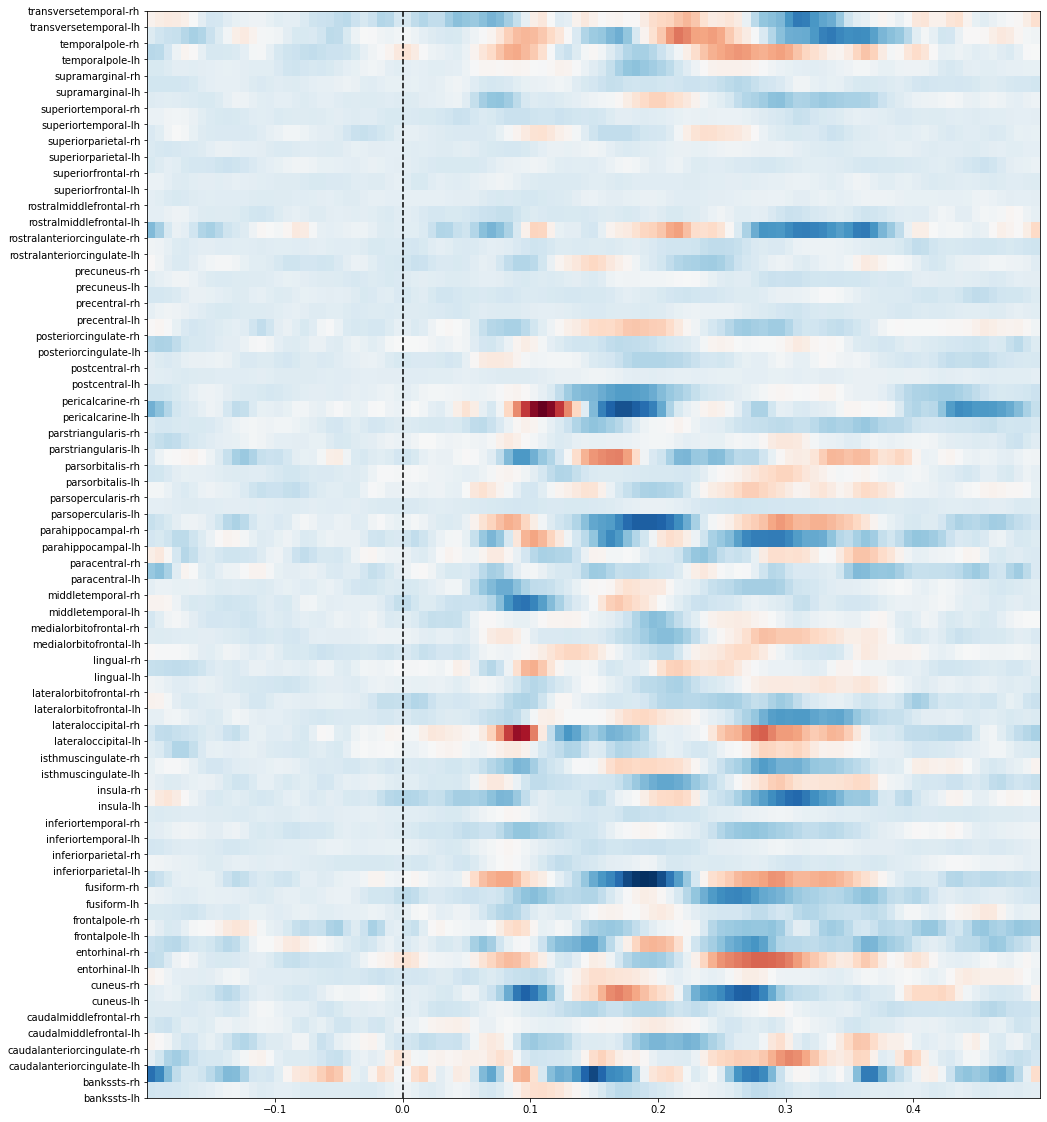

In [33]:
labels_name = [l.name for l in labels]
times = epochs.times

power_stc = np.dstack(tuple(rois_tc))
power_stc = xr.DataArray(power_stc, 
                         coords=[labels_name, times, range(power_stc.shape[-1])], 
                         dims=['rois', 'times', 'trials'])

fig, ax = plt.subplots(1,1, figsize=(16, 20))
ax.pcolormesh(power_stc.times, power_stc.rois, power_stc.mean('trials'), cmap='RdBu_r')
# ax.pcolormesh(power_stc.times, power_stc.rois, power_stc.loc[{'trials': 20}], cmap='RdBu_r')
ax.axvline(0, color='k', ls='--')

### Adding events dimension

In [34]:
epo_eve = epochs.events[:, 2]
power_stc = power_stc.assign_coords(events=('trials', epo_eve))
power_stc = power_stc.set_index({'trials': 'events'}, append=True)


### Plotting according to condition

/home/jerry/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jerry/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


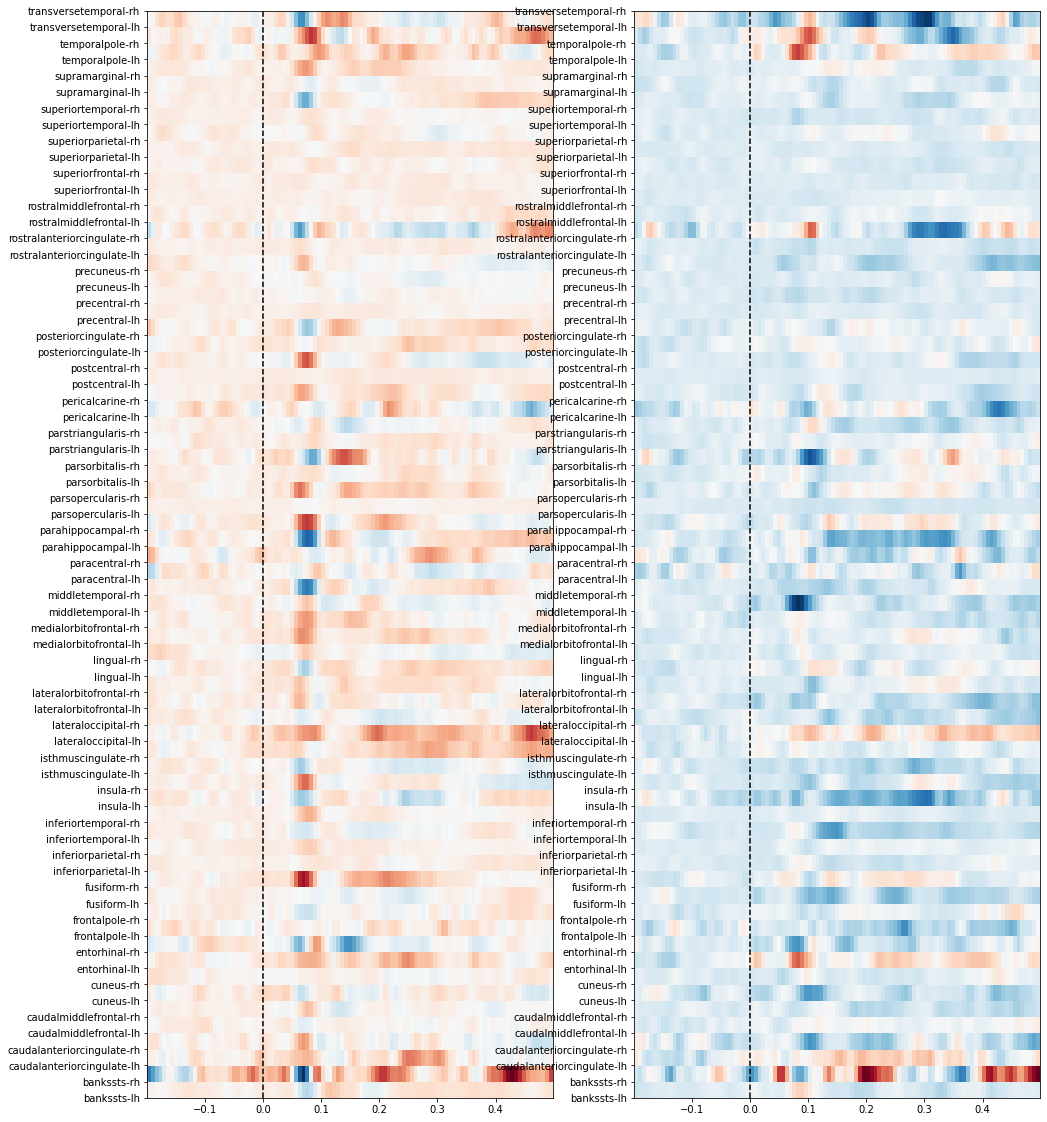

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 20))
for ax, ev in zip([ax1, ax2], [1, 2]):
    ax.pcolormesh(power_stc.times, power_stc.rois, power_stc.loc[{'events': ev}].mean('trials_level_0'), cmap='RdBu_r')
    # ax.pcolormesh(power_stc.times, power_stc.rois, power_stc.loc[{'trials': 20}], cmap='RdBu_r')
    ax.axvline(0, color='k', ls='--')
    

### Save results

In [36]:
os.makedirs(op.join(sample_data_folder, 'subjects', 'sample', 'results'), exist_ok=True)
# it's more convenient to keep events' id than trials' number
power_stc = power_stc.reset_index('trials_level_0', drop=True)
power_stc.to_netcdf(op.join(sample_data_folder, 'subjects', 'sample', 'results', 'sourcepowe_time_course.nc'))
